# Trying to get Diffusion to work
Notebook for trying to get diffusion to work. Merge ideas from different repositories.


In [1]:
from data.dataset import BEVFeaturesDataset, PaddDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.model import Palette
from config.config import config

In [2]:
print(config['path'])

{'network_checkpoint': '/home/mingdayang/FeatureBridgeMapping/checkpoints/PaletteDiffusion/PaletteDiffusion_model_long_training_net.pth', 'ema_network_checkpoint': '/home/mingdayang/FeatureBridgeMapping/checkpoints/PaletteDiffusion/PaletteDiffusion_model_long_training_ema_net.pth'}


In [3]:
checkpoint = torch.load(config['path']['network_checkpoint'], map_location='cpu')
model = Palette(checkpoint['model_config'], checkpoint['beta_schedule'], opts=config, rolling_statistics_cfg=checkpoint['rolling_stats_cfg'])
model.load_network()


Network loaded from /home/mingdayang/FeatureBridgeMapping/checkpoints/PaletteDiffusion/PaletteDiffusion_model_long_training_net.pth
EMA network loaded from /home/mingdayang/FeatureBridgeMapping/checkpoints/PaletteDiffusion/PaletteDiffusion_model_long_training_ema_net.pth


In [4]:
model.rolling_statistics_X.get_stats()

{'mean': tensor([[[[-0.0566]],
 
          [[ 0.0376]],
 
          [[ 0.0730]]]]),
 'var': tensor([[[[0.0805]],
 
          [[0.0958]],
 
          [[0.0061]]]]),
 'std': tensor([[[[0.2837]],
 
          [[0.3095]],
 
          [[0.0779]]]]),
 'p_samples': 10000}

/home/mingdayang/miniconda3/envs/unibev/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


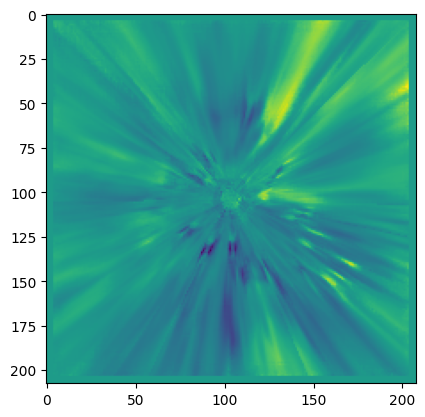

In [5]:
dataset = BEVFeaturesDataset(root_dir='/home/mingdayang/FeatureBridgeMapping/data/bev_features', transform=PaddDataset(pad_size=8))
one_sample = dataset[0]['img_bev_embed']
one_sample = torch.tensor(one_sample).unsqueeze(0)
one_sample = model.rolling_statistics_X.normalize(one_sample)
one_sample = one_sample.to(device=1)
plt.imshow(one_sample.cpu().squeeze().numpy()[0], cmap='viridis')

In [6]:
model.set_device(1)

In [7]:
output, ret_arr = model.val_step(y_cond=one_sample, use_ema=False, n_steps=10)

DPM-Solver: 100%|██████████| 10/10 [00:00<00:00, 10.98it/s]


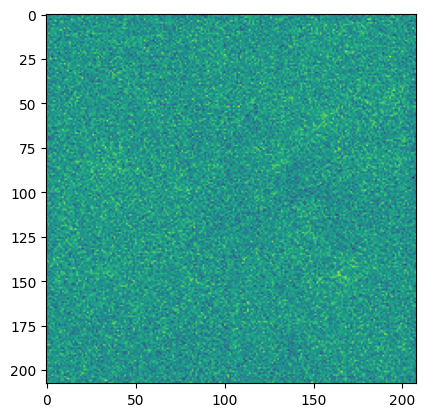

In [8]:
plt.imshow(model.rolling_statistics_y.denormalize(output.cpu()).squeeze().numpy()[0], cmap='viridis')

In [9]:
from torchvision import transforms
import torch

In [10]:
transforms.Normalize(mean=[0.5], std=[0.5])
tensor = torch.randn(1, 3, 64, 64)  # Example tensor

In [11]:
from models.network import Network
from models.sr3_modules.unet import UNet
unet = dict(
        in_channel=512,
        out_channel=256,
        inner_channel=256,
        norm_groups=32,
        channel_mults=(1, 1, 2, 2, 4),
        attn_res=[8],
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=208
)
beta_schedule = {
    'train': {
        'schedule': 'linear',
        'n_timestep': 1000,
        'linear_start': 1e-6,
        'linear_end': 1e-2,
    },
    'test': {
        'schedule': 'linear',
        'n_timestep': 1000,
        'linear_start': 1e-6,
        'linear_end': 1e-2,
    }
}
net = Network(unet, beta_schedule)
net.set_new_noise_schedule()
net.to('cuda')

Network(
  (denoise_fn): UNet(
    (noise_level_mlp): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=256, out_features=1024, bias=True)
      (2): Swish()
      (3): Linear(in_features=1024, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (noise_func): FeatureWiseAffine(
            (noise_func): Sequential(
              (0): Linear(in_features=256, out_features=256, bias=True)
            )
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(32, 256, eps=1e-05, affine=True)
              (1): Swish()
              (2): Identity()
              (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (block2): Block(
            (block): Sequential(
              (0): GroupNorm(32, 256, eps=1e-05

In [12]:
import torch
net.eval()
test_tensor = torch.randn(1, 256, 208, 208).to('cuda')
print(test_tensor.shape)
# output = net.restoration(y_cond=test_tensor, sample_num=1)
output = net.dpm_solver_sampling(y_cond=test_tensor, image_channels=256, img_size=(208, 208), n_steps=10, use_tqdm=True)

torch.Size([1, 256, 208, 208])


TypeError: dpm_solver_sampling() got an unexpected keyword argument 'image_channels'

In [5]:
from torchinfo import summary

summary(net, input_data=(test_tensor, torch.tensor([0]).to('cuda')))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [4]:
# Load all necessary libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import numpy as np
from data.dataset import BEVFeaturesDataset # dataset class
from IPython.display import display
from time import sleep

In [5]:
# Define model 
class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)


# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum("bnchw, bncyx -> bnhwyx", query, key).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


In [7]:
import random
import numpy as np
import math
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision.utils import make_grid


def tensor2img(tensor, out_type=np.uint8, min_max=(-1, 1)):
    '''
    Converts a torch Tensor into an image Numpy array
    Input: 4D(B,(3/1),H,W), 3D(C,H,W), or 2D(H,W), any range, RGB channel order
    Output: 3D(H,W,C) or 2D(H,W), [0,255], np.uint8 (default)
    '''
    tensor = tensor.clamp_(*min_max)  # clamp
    n_dim = tensor.dim()
    if n_dim == 4:
        n_img = len(tensor)
        img_np = make_grid(tensor, nrow=int(math.sqrt(n_img)), normalize=False).numpy()
        img_np = np.transpose(img_np, (1, 2, 0))  # HWC, RGB
    elif n_dim == 3:
        img_np = tensor.numpy()
        img_np = np.transpose(img_np, (1, 2, 0))  # HWC, RGB
    elif n_dim == 2:
        img_np = tensor.numpy()
    else:
        raise TypeError('Only support 4D, 3D and 2D tensor. But received with dimension: {:d}'.format(n_dim))
    if out_type == np.uint8:
        img_np = ((img_np+1) * 127.5).round()
        # Important. Unlike matlab, numpy.unit8() WILL NOT round by default.
    return img_np.astype(out_type).squeeze()

def postprocess(images):
	return [tensor2img(image) for image in images]


def set_seed(seed, gl_seed=0):
	"""  set random seed, gl_seed used in worker_init_fn function """
	if seed >=0 and gl_seed>=0:
		seed += gl_seed
		torch.manual_seed(seed)
		torch.cuda.manual_seed_all(seed)
		np.random.seed(seed)
		random.seed(seed)

	''' change the deterministic and benchmark maybe cause uncertain convolution behavior. 
		speed-reproducibility tradeoff https://pytorch.org/docs/stable/notes/randomness.html '''
	if seed >=0 and gl_seed>=0:  # slower, more reproducible
		torch.backends.cudnn.deterministic = True
		torch.backends.cudnn.benchmark = False
	else:  # faster, less reproducible
		torch.backends.cudnn.deterministic = False
		torch.backends.cudnn.benchmark = True

def set_gpu(args, distributed=False, rank=0):
	""" set parameter to gpu or ddp """
	if args is None:
		return None
	if distributed and isinstance(args, torch.nn.Module):
		return DDP(args.cuda(), device_ids=[rank], output_device=rank, broadcast_buffers=True, find_unused_parameters=True)
	else:
		return args.cuda()
		
def set_device(args, distributed=False, rank=0):
	""" set parameter to gpu or cpu """
	if torch.cuda.is_available():
		if isinstance(args, list):
			return (set_gpu(item, distributed, rank) for item in args)
		elif isinstance(args, dict):
			return {key:set_gpu(args[key], distributed, rank) for key in args}
		else:
			args = set_gpu(args, distributed, rank)
	return args




In [8]:
import os
from abc import abstractmethod
from functools import partial
import collections

import torch
import torch.nn as nn


CustomResult = collections.namedtuple('CustomResult', 'name result')

class BaseModel():
    def __init__(self, opt, phase_loader, val_loader, metrics, logger, writer):
        """ init model with basic input, which are from __init__(**kwargs) function in inherited class """
        self.opt = opt
        self.phase = opt['phase']
        self.set_device = partial(Util.set_device, rank=opt['global_rank'])

        ''' optimizers and schedulers '''
        self.schedulers = []
        self.optimizers = []

        ''' process record '''
        self.batch_size = self.opt['datasets'][self.phase]['dataloader']['args']['batch_size']
        self.epoch = 0
        self.iter = 0 

        self.phase_loader = phase_loader
        self.val_loader = val_loader
        self.metrics = metrics

        ''' logger to log file, which only work on GPU 0. writer to tensorboard and result file '''
        self.logger = logger
        self.writer = writer
        self.results_dict = CustomResult([],[]) # {"name":[], "result":[]}

    def train(self):
        while self.epoch <= self.opt['train']['n_epoch'] and self.iter <= self.opt['train']['n_iter']:
            self.epoch += 1
            if self.opt['distributed']:
                ''' sets the epoch for this sampler. When :attr:`shuffle=True`, this ensures all replicas use a different random ordering for each epoch '''
                self.phase_loader.sampler.set_epoch(self.epoch) 

            train_log = self.train_step()

            ''' save logged informations into log dict ''' 
            train_log.update({'epoch': self.epoch, 'iters': self.iter})

            ''' print logged informations to the screen and tensorboard ''' 
            for key, value in train_log.items():
                self.logger.info('{:5s}: {}\t'.format(str(key), value))
            
            if self.epoch % self.opt['train']['save_checkpoint_epoch'] == 0:
                self.logger.info('Saving the self at the end of epoch {:.0f}'.format(self.epoch))
                self.save_everything()

            if self.epoch % self.opt['train']['val_epoch'] == 0:
                self.logger.info("\n\n\n------------------------------Validation Start------------------------------")
                if self.val_loader is None:
                    self.logger.warning('Validation stop where dataloader is None, Skip it.')
                else:
                    val_log = self.val_step()
                    for key, value in val_log.items():
                        self.logger.info('{:5s}: {}\t'.format(str(key), value))
                self.logger.info("\n------------------------------Validation End------------------------------\n\n")
        self.logger.info('Number of Epochs has reached the limit, End.')

    def test(self):
        pass

    @abstractmethod
    def train_step(self):
        raise NotImplementedError('You must specify how to train your networks.')

    @abstractmethod
    def val_step(self):
        raise NotImplementedError('You must specify how to do validation on your networks.')

    def test_step(self):
        pass
    
    def print_network(self, network):
        """ print network structure, only work on GPU 0 """
        if self.opt['global_rank'] !=0:
            return
        if isinstance(network, nn.DataParallel) or isinstance(network, nn.parallel.DistributedDataParallel):
            network = network.module
        
        s, n = str(network), sum(map(lambda x: x.numel(), network.parameters()))
        net_struc_str = '{}'.format(network.__class__.__name__)
        self.logger.info('Network structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        self.logger.info(s)

    def save_network(self, network, network_label):
        """ save network structure, only work on GPU 0 """
        if self.opt['global_rank'] !=0:
            return
        save_filename = '{}_{}.pth'.format(self.epoch, network_label)
        save_path = os.path.join(self.opt['path']['checkpoint'], save_filename)
        if isinstance(network, nn.DataParallel) or isinstance(network, nn.parallel.DistributedDataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, save_path)

    def load_network(self, network, network_label, strict=True):
        if self.opt['path']['resume_state'] is None:
            return 
        self.logger.info('Beign loading pretrained model [{:s}] ...'.format(network_label))

        model_path = "{}_{}.pth".format(self. opt['path']['resume_state'], network_label)
        
        if not os.path.exists(model_path):
            self.logger.warning('Pretrained model in [{:s}] is not existed, Skip it'.format(model_path))
            return

        self.logger.info('Loading pretrained model from [{:s}] ...'.format(model_path))
        if isinstance(network, nn.DataParallel) or isinstance(network, nn.parallel.DistributedDataParallel):
            network = network.module
        network.load_state_dict(torch.load(model_path, map_location = lambda storage, loc: Util.set_device(storage)), strict=strict)

    def save_training_state(self):
        """ saves training state during training, only work on GPU 0 """
        if self.opt['global_rank'] !=0:
            return
        assert isinstance(self.optimizers, list) and isinstance(self.schedulers, list), 'optimizers and schedulers must be a list.'
        state = {'epoch': self.epoch, 'iter': self.iter, 'schedulers': [], 'optimizers': []}
        for s in self.schedulers:
            state['schedulers'].append(s.state_dict())
        for o in self.optimizers:
            state['optimizers'].append(o.state_dict())
        save_filename = '{}.state'.format(self.epoch)
        save_path = os.path.join(self.opt['path']['checkpoint'], save_filename)
        torch.save(state, save_path)

    def resume_training(self):
        """ resume the optimizers and schedulers for training, only work when phase is test or resume training enable """
        if self.phase!='train' or self. opt['path']['resume_state'] is None:
            return
        self.logger.info('Beign loading training states'.format())
        assert isinstance(self.optimizers, list) and isinstance(self.schedulers, list), 'optimizers and schedulers must be a list.'
        
        state_path = "{}.state".format(self. opt['path']['resume_state'])
        
        if not os.path.exists(state_path):
            self.logger.warning('Training state in [{:s}] is not existed, Skip it'.format(state_path))
            return

        self.logger.info('Loading training state for [{:s}] ...'.format(state_path))
        resume_state = torch.load(state_path, map_location = lambda storage, loc: self.set_device(storage))
        
        resume_optimizers = resume_state['optimizers']
        resume_schedulers = resume_state['schedulers']
        assert len(resume_optimizers) == len(self.optimizers), 'Wrong lengths of optimizers {} != {}'.format(len(resume_optimizers), len(self.optimizers))
        assert len(resume_schedulers) == len(self.schedulers), 'Wrong lengths of schedulers {} != {}'.format(len(resume_schedulers), len(self.schedulers))
        for i, o in enumerate(resume_optimizers):
            self.optimizers[i].load_state_dict(o)
        for i, s in enumerate(resume_schedulers):
            self.schedulers[i].load_state_dict(s)

        self.epoch = resume_state['epoch']
        self.iter = resume_state['iter']

    def load_everything(self):
        pass 
    
    @abstractmethod
    def save_everything(self):
        raise NotImplementedError('You must specify how to save your networks, optimizers and schedulers.')

In [9]:
class BaseNetwork(nn.Module):
  def __init__(self, init_type='kaiming', gain=0.02):
    super(BaseNetwork, self).__init__()
    self.init_type = init_type
    self.gain = gain

  def init_weights(self):
    """
    initialize network's weights
    init_type: normal | xavier | kaiming | orthogonal
    https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
    """
    
    def init_func(m):
      classname = m.__class__.__name__
      if classname.find('InstanceNorm2d') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
          nn.init.constant_(m.weight.data, 1.0)
        if hasattr(m, 'bias') and m.bias is not None:
          nn.init.constant_(m.bias.data, 0.0)
      elif hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if self.init_type == 'normal':
          nn.init.normal_(m.weight.data, 0.0, self.gain)
        elif self.init_type == 'xavier':
          nn.init.xavier_normal_(m.weight.data, gain=self.gain)
        elif self.init_type == 'xavier_uniform':
          nn.init.xavier_uniform_(m.weight.data, gain=1.0)
        elif self.init_type == 'kaiming':
          nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif self.init_type == 'orthogonal':
          nn.init.orthogonal_(m.weight.data, gain=self.gain)
        elif self.init_type == 'none':  # uses pytorch's default init method
          m.reset_parameters()
        else:
          raise NotImplementedError('initialization method [%s] is not implemented' % self.init_type)
        if hasattr(m, 'bias') and m.bias is not None:
          nn.init.constant_(m.bias.data, 0.0)

    self.apply(init_func)
    # propagate to children
    for m in self.children():
      if hasattr(m, 'init_weights'):
        m.init_weights(self.init_type, self.gain)



    

In [ ]:
import math
import torch
from inspect import isfunction
from functools import partial
import numpy as np
from tqdm import tqdm
from core.base_network import BaseNetwork
import torch.nn.functional as F
import copy

class EMA():
    def __init__(self, beta=0.9999):
        super().__init__()
        self.beta = beta
    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new
    
class Palette(BaseModel):
    def __init__(self, networks, losses, sample_num, task, optimizers, ema_scheduler=None, **kwargs):
        ''' must to init BaseModel with kwargs '''
        super(Palette, self).__init__(**kwargs)

        ''' networks, dataloder, optimizers, losses, etc. '''
        self.loss_fn = losses[0]
        self.netG = networks[0]
        if ema_scheduler is not None:
            self.ema_scheduler = ema_scheduler
            self.netG_EMA = copy.deepcopy(self.netG)
            self.EMA = EMA(beta=self.ema_scheduler['ema_decay'])
        else:
            self.ema_scheduler = None
        
        ''' networks can be a list, and must convert by self.set_device function if using multiple GPU. '''
        self.netG = self.set_device(self.netG, distributed=self.opt['distributed'])
        if self.ema_scheduler is not None:
            self.netG_EMA = self.set_device(self.netG_EMA, distributed=self.opt['distributed'])
        self.load_networks()

        self.optG = torch.optim.Adam(list(filter(lambda p: p.requires_grad, self.netG.parameters())), **optimizers[0])
        self.optimizers.append(self.optG)
        self.resume_training() 

        if self.opt['distributed']:
            self.netG.module.set_loss(self.loss_fn)
            self.netG.module.set_new_noise_schedule(phase=self.phase)
        else:
            self.netG.set_loss(self.loss_fn)
            self.netG.set_new_noise_schedule(phase=self.phase)

        ''' can rewrite in inherited class for more informations logging '''
        self.train_metrics = LogTracker(*[m.__name__ for m in losses], phase='train')
        self.val_metrics = LogTracker(*[m.__name__ for m in self.metrics], phase='val')
        self.test_metrics = LogTracker(*[m.__name__ for m in self.metrics], phase='test')

        self.sample_num = sample_num
        self.task = task
        
    def set_input(self, data):
        ''' must use set_device in tensor '''
        self.cond_image = self.set_device(data.get('cond_image'))
        self.gt_image = self.set_device(data.get('gt_image'))
        self.mask = self.set_device(data.get('mask'))
        self.mask_image = data.get('mask_image')
        self.path = data['path']
        self.batch_size = len(data['path'])
    
    def get_current_visuals(self, phase='train'):
        dict = {
            'gt_image': (self.gt_image.detach()[:].float().cpu()+1)/2,
            'cond_image': (self.cond_image.detach()[:].float().cpu()+1)/2,
        }
        if self.task in ['inpainting','uncropping']:
            dict.update({
                'mask': self.mask.detach()[:].float().cpu(),
                'mask_image': (self.mask_image+1)/2,
            })
        if phase != 'train':
            dict.update({
                'output': (self.output.detach()[:].float().cpu()+1)/2
            })
        return dict

    def save_current_results(self):
        ret_path = []
        ret_result = []
        for idx in range(self.batch_size):
            ret_path.append('GT_{}'.format(self.path[idx]))
            ret_result.append(self.gt_image[idx].detach().float().cpu())

            ret_path.append('Process_{}'.format(self.path[idx]))
            ret_result.append(self.visuals[idx::self.batch_size].detach().float().cpu())
            
            ret_path.append('Out_{}'.format(self.path[idx]))
            ret_result.append(self.visuals[idx-self.batch_size].detach().float().cpu())
        
        if self.task in ['inpainting','uncropping']:
            ret_path.extend(['Mask_{}'.format(name) for name in self.path])
            ret_result.extend(self.mask_image)

        self.results_dict = self.results_dict._replace(name=ret_path, result=ret_result)
        return self.results_dict._asdict()

    def train_step(self):
        self.netG.train()
        self.train_metrics.reset()
        for train_data in tqdm.tqdm(self.phase_loader):
            self.set_input(train_data)
            self.optG.zero_grad()
            loss = self.netG(self.gt_image, self.cond_image, mask=self.mask)
            loss.backward()
            self.optG.step()

            self.iter += self.batch_size
            self.writer.set_iter(self.epoch, self.iter, phase='train')
            self.train_metrics.update(self.loss_fn.__name__, loss.item())
            if self.iter % self.opt['train']['log_iter'] == 0:
                for key, value in self.train_metrics.result().items():
                    self.logger.info('{:5s}: {}\t'.format(str(key), value))
                    self.writer.add_scalar(key, value)
                for key, value in self.get_current_visuals().items():
                    self.writer.add_images(key, value)
            if self.ema_scheduler is not None:
                if self.iter > self.ema_scheduler['ema_start'] and self.iter % self.ema_scheduler['ema_iter'] == 0:
                    self.EMA.update_model_average(self.netG_EMA, self.netG)

        for scheduler in self.schedulers:
            scheduler.step()
        return self.train_metrics.result()
    
    def val_step(self):
        self.netG.eval()
        self.val_metrics.reset()
        with torch.no_grad():
            for val_data in tqdm.tqdm(self.val_loader):
                self.set_input(val_data)
                if self.opt['distributed']:
                    if self.task in ['inpainting','uncropping']:
                        self.output, self.visuals = self.netG.module.restoration(self.cond_image, y_t=self.cond_image, 
                            y_0=self.gt_image, mask=self.mask, sample_num=self.sample_num)
                    else:
                        self.output, self.visuals = self.netG.module.restoration(self.cond_image, sample_num=self.sample_num)
                else:
                    if self.task in ['inpainting','uncropping']:
                        self.output, self.visuals = self.netG.restoration(self.cond_image, y_t=self.cond_image, 
                            y_0=self.gt_image, mask=self.mask, sample_num=self.sample_num)
                    else:
                        self.output, self.visuals = self.netG.restoration(self.cond_image, sample_num=self.sample_num)
                    
                self.iter += self.batch_size
                self.writer.set_iter(self.epoch, self.iter, phase='val')

                for met in self.metrics:
                    key = met.__name__
                    value = met(self.gt_image, self.output)
                    self.val_metrics.update(key, value)
                    self.writer.add_scalar(key, value)
                for key, value in self.get_current_visuals(phase='val').items():
                    self.writer.add_images(key, value)
                self.writer.save_images(self.save_current_results())

        return self.val_metrics.result()

    def test(self):
        self.netG.eval()
        self.test_metrics.reset()
        with torch.no_grad():
            for phase_data in tqdm.tqdm(self.phase_loader):
                self.set_input(phase_data)
                if self.opt['distributed']:
                    if self.task in ['inpainting','uncropping']:
                        self.output, self.visuals = self.netG.module.restoration(self.cond_image, y_t=self.cond_image, 
                            y_0=self.gt_image, mask=self.mask, sample_num=self.sample_num)
                    else:
                        self.output, self.visuals = self.netG.module.restoration(self.cond_image, sample_num=self.sample_num)
                else:
                    if self.task in ['inpainting','uncropping']:
                        self.output, self.visuals = self.netG.restoration(self.cond_image, y_t=self.cond_image, 
                            y_0=self.gt_image, mask=self.mask, sample_num=self.sample_num)
                    else:
                        self.output, self.visuals = self.netG.restoration(self.cond_image, sample_num=self.sample_num)
                        
                self.iter += self.batch_size
                self.writer.set_iter(self.epoch, self.iter, phase='test')
                for met in self.metrics:
                    key = met.__name__
                    value = met(self.gt_image, self.output)
                    self.test_metrics.update(key, value)
                    self.writer.add_scalar(key, value)
                for key, value in self.get_current_visuals(phase='test').items():
                    self.writer.add_images(key, value)
                self.writer.save_images(self.save_current_results())
        
        test_log = self.test_metrics.result()
        ''' save logged informations into log dict ''' 
        test_log.update({'epoch': self.epoch, 'iters': self.iter})

        ''' print logged informations to the screen and tensorboard ''' 
        for key, value in test_log.items():
            self.logger.info('{:5s}: {}\t'.format(str(key), value))

    def load_networks(self):
        """ save pretrained model and training state, which only do on GPU 0. """
        if self.opt['distributed']:
            netG_label = self.netG.module.__class__.__name__
        else:
            netG_label = self.netG.__class__.__name__
        self.load_network(network=self.netG, network_label=netG_label, strict=False)
        if self.ema_scheduler is not None:
            self.load_network(network=self.netG_EMA, network_label=netG_label+'_ema', strict=False)

    def save_everything(self):
        """ load pretrained model and training state. """
        if self.opt['distributed']:
            netG_label = self.netG.module.__class__.__name__
        else:
            netG_label = self.netG.__class__.__name__
        self.save_network(network=self.netG, network_label=netG_label)
        if self.ema_scheduler is not None:
            self.save_network(network=self.netG_EMA, network_label=netG_label+'_ema')
        self.save_training_state()

class Network(BaseNetwork):
    def __init__(self, unet, beta_schedule, module_name='sr3', **kwargs):
        super(Network, self).__init__(**kwargs)
        # if module_name == 'sr3':
        #     from .sr3_modules.unet import UNet
        # elif module_name == 'guided_diffusion':
        #     from .guided_diffusion_modules.unet import UNet
        
        self.denoise_fn = UNet(**unet)
        self.beta_schedule = beta_schedule

    def set_loss(self, loss_fn):
        self.loss_fn = loss_fn

    def set_new_noise_schedule(self, device=torch.device('cuda'), phase='train'):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)
        betas = make_beta_schedule(**self.beta_schedule[phase])
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        
        gammas = np.cumprod(alphas, axis=0)
        gammas_prev = np.append(1., gammas[:-1])

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('gammas', to_torch(gammas))
        self.register_buffer('alpha_t_bar', to_torch(gammas))
        self.register_buffer('sqrt_recip_gammas', to_torch(np.sqrt(1. / gammas)))
        self.register_buffer('sqrt_recipm1_gammas', to_torch(np.sqrt(1. / gammas - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - gammas_prev) / (1. - gammas)
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(betas * np.sqrt(gammas_prev) / (1. - gammas)))
        self.register_buffer('posterior_mean_coef2', to_torch((1. - gammas_prev) * np.sqrt(alphas) / (1. - gammas)))

    def predict_start_from_noise(self, y_t, t, noise):
        return (
            extract(self.sqrt_recip_gammas, t, y_t.shape) * y_t -
            extract(self.sqrt_recipm1_gammas, t, y_t.shape) * noise
        )

    def q_posterior(self, y_0_hat, y_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, y_t.shape) * y_0_hat +
            extract(self.posterior_mean_coef2, t, y_t.shape) * y_t
        )
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, y_t.shape)
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, y_t, t, clip_denoised: bool, y_cond=None):
        noise_level = extract(self.gammas, t, x_shape=(1, 1)).to(y_t.device)
        y_0_hat = self.predict_start_from_noise(
                y_t, t=t, noise=self.denoise_fn(torch.cat([y_cond, y_t], dim=1), noise_level))

        if clip_denoised:
            y_0_hat.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            y_0_hat=y_0_hat, y_t=y_t, t=t)
        return model_mean, posterior_log_variance

    def q_sample(self, y_0, sample_gammas, noise=None):
        noise = default(noise, lambda: torch.randn_like(y_0))
        return (
            sample_gammas.sqrt() * y_0 +
            (1 - sample_gammas).sqrt() * noise
        )

    @torch.no_grad()
    def p_sample(self, y_t, t, clip_denoised=True, y_cond=None):
        model_mean, model_log_variance = self.p_mean_variance(
            y_t=y_t, t=t, clip_denoised=clip_denoised, y_cond=y_cond)
        noise = torch.randn_like(y_t) if any(t>0) else torch.zeros_like(y_t)
        return model_mean + noise * (0.5 * model_log_variance).exp()


    @torch.no_grad()
    def ddim_sample(self, y_t, t, prev_t, clip_denoised=True, y_cond=None, eta=0.0):
        alpha_t = extract(self.alpha_t_bar, t, y_t.shape)
        alpha_t_prev = extract(self.alpha_t_bar, prev_t, y_t.shape)

        epsilon_theta_t = self.denoise_fn(torch.cat([y_cond, y_t], dim=1), alpha_t)

        y_0_hat = (y_t - torch.sqrt(1.0 - alpha_t) * epsilon_theta_t) / torch.sqrt(alpha_t)
        if clip_denoised:
            y_0_hat.clamp_(-1.0, 1.0)

        sigma_t = eta * torch.sqrt((1.0 - alpha_t_prev) / (1.0 - alpha_t) * (1.0 - alpha_t / alpha_t_prev))
        noise = torch.randn_like(y_t) if eta > 0.0 and (prev_t > 0).any() else torch.zeros_like(y_t)
        y_t_minus_one = (
            torch.sqrt(alpha_t_prev) * y_0_hat +
            torch.sqrt(1.0 - alpha_t_prev - sigma_t ** 2) * epsilon_theta_t +
            sigma_t * noise
        )
        return y_t_minus_one


    @torch.no_grad()
    def ddim_restoration_full(self, y_cond, y_t=None, y_0=None, mask=None, sample_num=8, eta=0.0):
        b, *_ = y_cond.shape

        assert self.num_timesteps > sample_num, 'num_timesteps must greater than sample_num'
        sample_inter = (self.num_timesteps//sample_num)
        
        y_t = default(y_t, lambda: torch.randn_like(y_cond))
        ret_arr = y_t
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            t = torch.full((b,), i, device=y_cond.device, dtype=torch.long)
            prev_t = torch.full((b,), max(i - sample_inter, 0), device=y_cond.device, dtype=torch.long)
            y_t = self.ddim_sample(y_t, t, prev_t, clip_denoised=True, y_cond=y_cond, eta=eta)
            if mask is not None:
                y_t = y_0*(1.-mask) + mask*y_t
            if i % sample_inter == 0:
                ret_arr = torch.cat([ret_arr, y_t], dim=0)
        return y_t, ret_arr

    @torch.no_grad()
    def ddim_restoration(self, y_cond, y_t=None, y_0=None, mask=None, sample_num=8, eta=0.0, step=100):
        b, *_ = y_cond.shape

        assert self.num_timesteps > 0 and step > 0, 'step must be positive'
        assert sample_num > 0, 'sample_num must be positive'

        y_t = default(y_t, lambda: torch.randn_like(y_cond))
        ret_arr = y_t

        time_steps = np.linspace(0, self.num_timesteps - 1, step, dtype=np.int64).tolist()
        save_indices = set(np.linspace(0, len(time_steps) - 1, sample_num, dtype=np.int64).tolist())

        for i in tqdm(reversed(range(0, len(time_steps))), desc='sampling loop time step', total=len(time_steps)):
            t_val = time_steps[i]
            prev_t_val = time_steps[i - 1] if i > 0 else 0
            t = torch.full((b,), t_val, device=y_cond.device, dtype=torch.long)
            prev_t = torch.full((b,), prev_t_val, device=y_cond.device, dtype=torch.long)
            y_t = self.ddim_sample(y_t, t, prev_t, clip_denoised=True, y_cond=y_cond, eta=eta)
            if mask is not None:
                y_t = y_0*(1.-mask) + mask*y_t
            if i in save_indices:
                ret_arr = torch.cat([ret_arr, y_t], dim=0)
        ret_arr = torch.cat([ret_arr, y_t], dim=0)
        return y_t, ret_arr

    @torch.no_grad()
    def restoration(self, y_cond, y_t=None, y_0=None, mask=None, sample_num=8):
        b, *_ = y_cond.shape

        assert self.num_timesteps > sample_num, 'num_timesteps must greater than sample_num'
        sample_inter = (self.num_timesteps//sample_num)
        
        y_t = default(y_t, lambda: torch.randn_like(y_cond))
        ret_arr = y_t
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            t = torch.full((b,), i, device=y_cond.device, dtype=torch.long)
            y_t = self.p_sample(y_t, t, y_cond=y_cond)
            if mask is not None:
                y_t = y_0*(1.-mask) + mask*y_t
            if i % sample_inter == 0:
                ret_arr = torch.cat([ret_arr, y_t], dim=0)
        return y_t, ret_arr


    def forward(self, y_0, y_cond=None, mask=None, noise=None):
        # sampling from p(gammas)
        b, *_ = y_0.shape
        t = torch.randint(1, self.num_timesteps, (b,), device=y_0.device).long()
        gamma_t1 = extract(self.gammas, t-1, x_shape=(1, 1))
        sqrt_gamma_t2 = extract(self.gammas, t, x_shape=(1, 1))
        sample_gammas = (sqrt_gamma_t2-gamma_t1) * torch.rand((b, 1), device=y_0.device) + gamma_t1
        sample_gammas = sample_gammas.view(b, -1)

        noise = default(noise, lambda: torch.randn_like(y_0))
        y_noisy = self.q_sample(
            y_0=y_0, sample_gammas=sample_gammas.view(-1, 1, 1, 1), noise=noise)

        if mask is not None:
            noise_hat = self.denoise_fn(torch.cat([y_cond, y_noisy*mask+(1.-mask)*y_0], dim=1), sample_gammas)
            loss = self.loss_fn(mask*noise, mask*noise_hat)
        else:
            noise_hat = self.denoise_fn(torch.cat([y_cond, y_noisy], dim=1), sample_gammas)
            loss = self.loss_fn(noise, noise_hat)
        return loss


# gaussian diffusion trainer class
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def extract(a, t, x_shape=(1,1,1,1)):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

# beta_schedule function
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas

def make_beta_schedule(schedule, n_timestep, linear_start=1e-6, linear_end=1e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas

